In [3]:
import os

import numpy as np
import cv2
from skimage.io import imread
from utils import data_loader
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pathlib

ROOT_PATH = str(pathlib.Path().absolute())
DATA_STORAGE_PATH = '/data_storage/'
STORAGE_PATH = ROOT_PATH + DATA_STORAGE_PATH

DATASET_PATH = '/datasets/final_data'
FINAL_DATASET_PATH = ROOT_PATH + DATASET_PATH

TRAIN_PATH_IMAGES = FINAL_DATASET_PATH + '/train/images/'
TEST_PATH_IMAGES = FINAL_DATASET_PATH + '/test/images/'
VALI_PATH_IMAGES = FINAL_DATASET_PATH + '/validation/images/'

TRAIN_PATH_MASKS = FINAL_DATASET_PATH + '/train/masks/'
TEST_PATH_MASKS = FINAL_DATASET_PATH + '/test/masks/'
VALI_PATH_MASKS = FINAL_DATASET_PATH + '/validation/masks/'

file_ids = next(os.walk(TRAIN_PATH_IMAGES))[2]

file_ids, val_ids = train_test_split(file_ids, test_size=0.1, random_state=2022)

In [5]:
val_ids

['Image2899.jpg',
 'Image3656.jpg',
 'Image2598.jpg',
 'Image4550.jpg',
 'image-2-000177.jpg',
 'Image767.jpg',
 'Image2962.jpg',
 'Image4103.jpg',
 'Image4544.jpg',
 'image7139.jpg',
 'image6748.jpg',
 'Image2929.jpg',
 'Image3959.jpg',
 'image7634.jpg',
 'Image1212.jpg',
 'Image3902.jpg',
 'Image728.jpg',
 'Image738.jpg',
 'image6383.jpg',
 'Image4750.jpg',
 'image7718.jpg',
 'Image1956.jpg',
 'Image4449.jpg',
 'Image896.jpg',
 'Image2204.jpg',
 'Image3434.jpg',
 'Image2554.jpg',
 'Image1613.jpg',
 'Image3953.jpg',
 'Image314.jpg',
 'Image3084.jpg',
 'Image249.jpg',
 'Image4880.jpg',
 'Image3055.jpg',
 'image-1-000151.jpg',
 'Image642.jpg',
 'image7287.jpg',
 'image6081.jpg',
 'Image1122.jpg',
 'Image2224.jpg',
 'image-1-000068.jpg',
 'Image1633.jpg',
 'Image1567.jpg',
 'Image2507.jpg',
 'Image3200.jpg',
 'image-1-000214.jpg',
 'Image4111.jpg',
 'image6747.jpg',
 'Image1201.jpg',
 'Image4138.jpg',
 'Image4345.jpg',
 'image6878.jpg',
 'Image1826.jpg',
 'Image1537.jpg',
 'Image2898.jpg

In [2]:
(train_data, train_mask) = data_loader.load_bulk_data('unet_mini_data', section='train')
(val_data, val_mask) = data_loader.load_bulk_data('unet_mini_data', section='val')
(test_data, test_mask) = data_loader.load_bulk_data('unet_mini_data', section='test')

In [3]:
train_data.shape

(18, 192, 256, 3)

In [5]:
train_mask.shape

(18, 192, 256, 1)

In [24]:
shape_test = (192, 256)
truth_ = imread('datasets/final_data/train/masks/image-2-000268.png', as_gray=True)
truth = np.zeros(shape_test)

truth, points = data_loader.mapping_rescale_dot(truth, truth_)

In [26]:
np.sum(truth)

61.0

In [13]:
train_data.shape

(6596, 192, 256, 3)

In [14]:
test = train_data[1]

In [15]:
test_mask = train_mask[1]

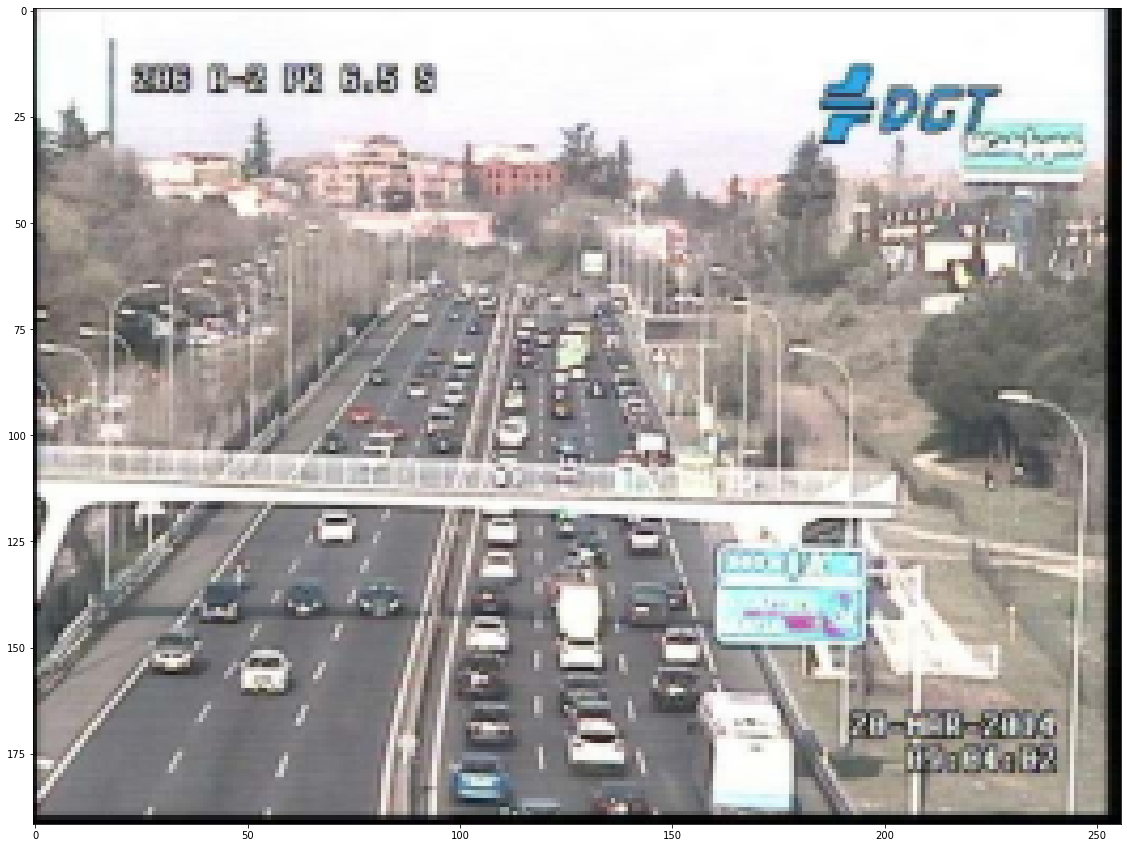

In [16]:
plt.figure(figsize=(30, 15))
plt.imshow(test, cmap='gray')
plt.show()

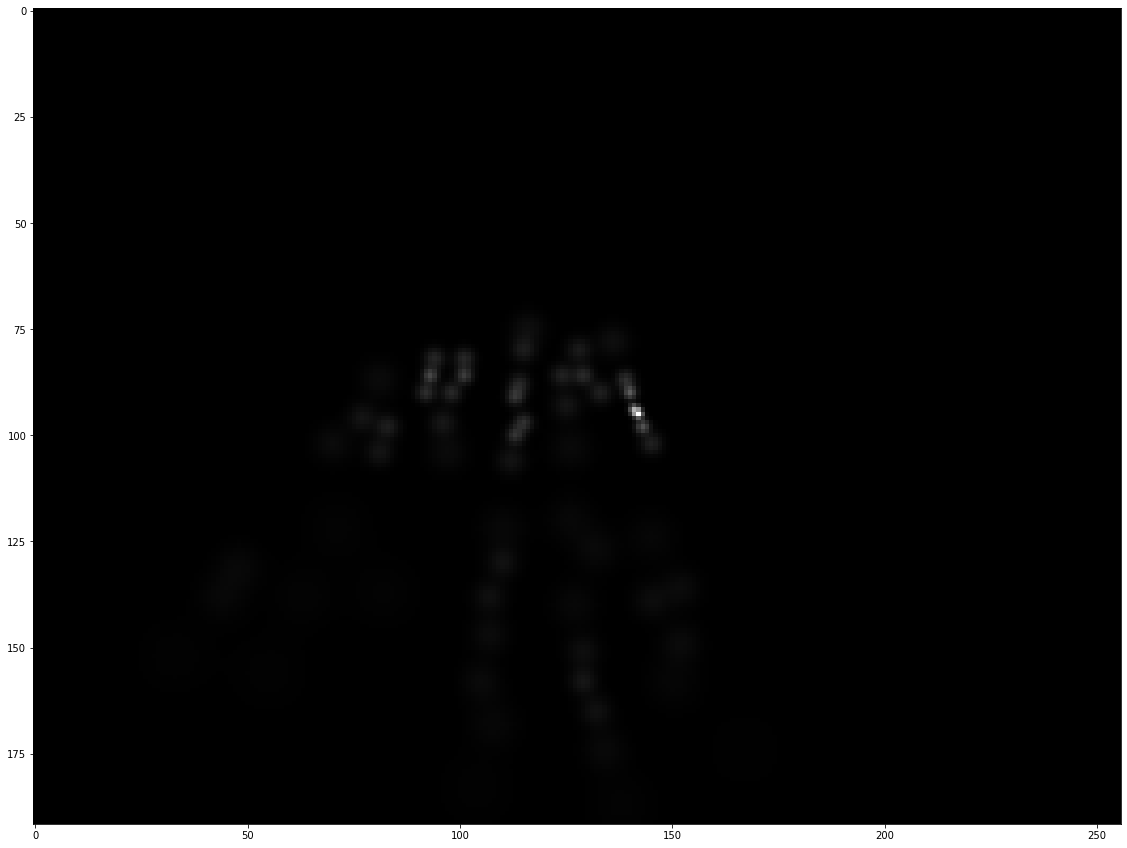

In [27]:
plt.figure(figsize=(30, 15))
plt.imshow(test_mask, cmap='gray')
plt.show()

In [23]:
np.sum(test_mask)

60.70148

In [32]:
test_mask.min()

0.0

In [2]:
mask_size = (192, 256)
mask = np.zeros(mask_size)
# mask_ = imread('examples/Image10.png', as_gray=True)
mask_ = np.zeros(mask_size)
mask_[125][125] = 1.0

In [3]:
mask, non_zero_points = data_loader.mapping_rescale_dot(mask, mask_)

In [4]:
mask.shape

(192, 256)

In [5]:
dm = data_loader.gaussian_filter_density(mask, np.fliplr(non_zero_points), k_nearest=3, fixed_sigma=None)

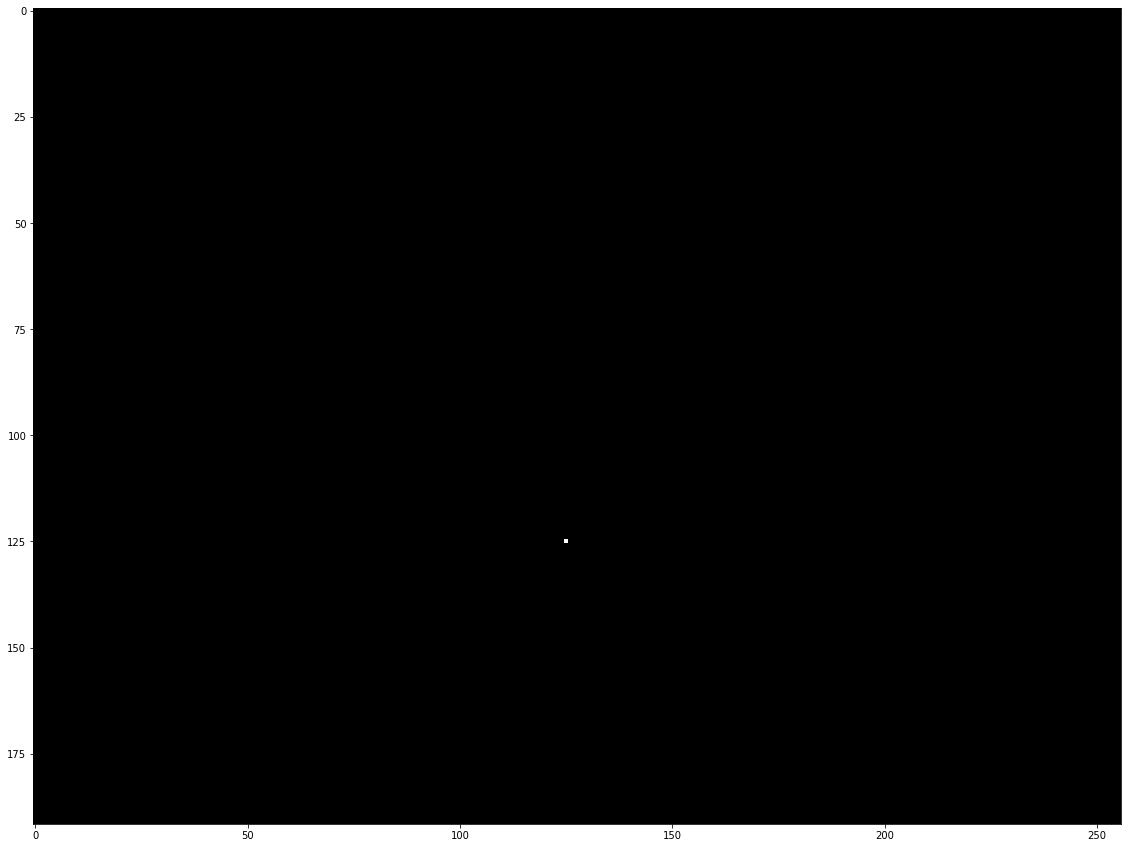

In [6]:
plt.figure(figsize=(30, 15))
plt.imshow(mask, cmap='gray')
plt.show()

In [7]:
np.sum(dm)

1.0

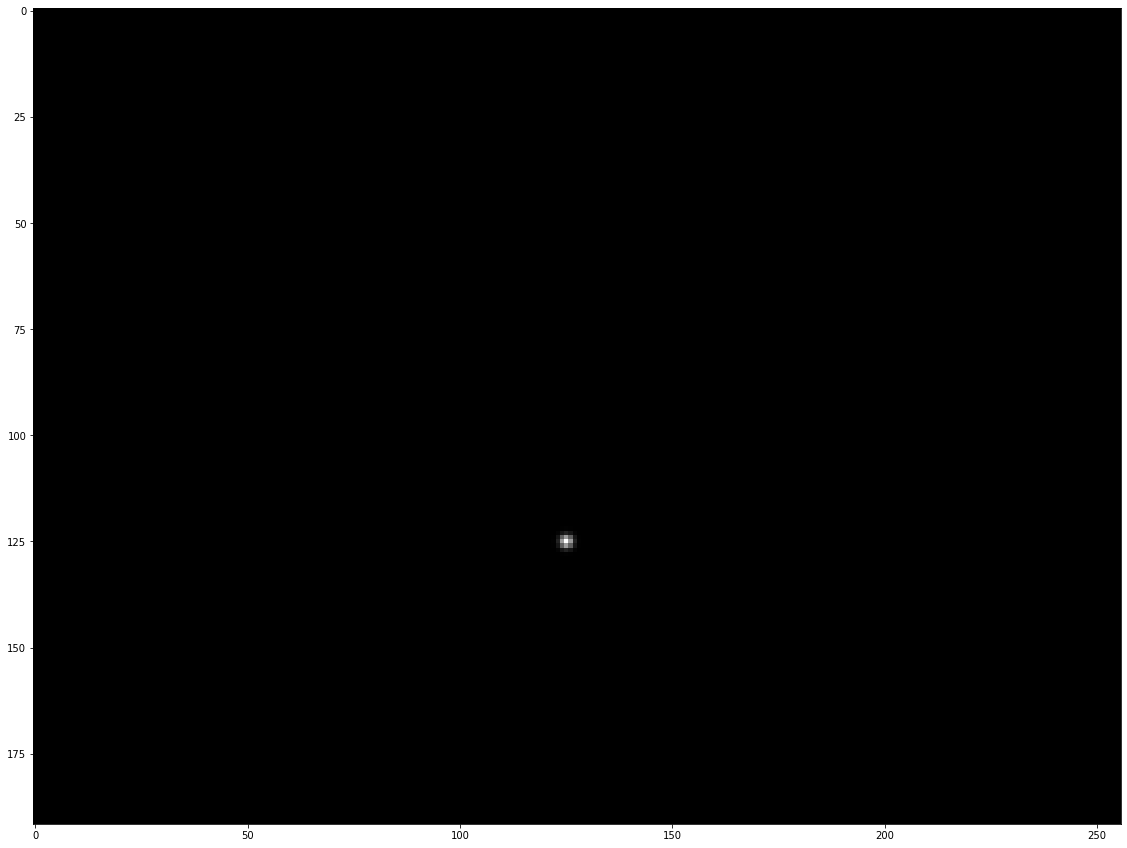

In [8]:
plt.figure(figsize=(30, 15))
plt.imshow(dm, cmap='gray')
plt.show()

In [9]:
dm.shape

(192, 256)

In [30]:
dm_resize = cv2.resize(dm,(int(dm.shape[1]/8),int(dm.shape[0]/8)),interpolation = cv2.INTER_AREA)

In [31]:
dm_resize1 = resize(dm, (int(dm.shape[0]/8),int(dm.shape[1]/8)), mode='constant', preserve_range=True)

In [32]:
dm_resize.shape

(24, 32)

In [33]:
dm_resize1.shape

(24, 32)

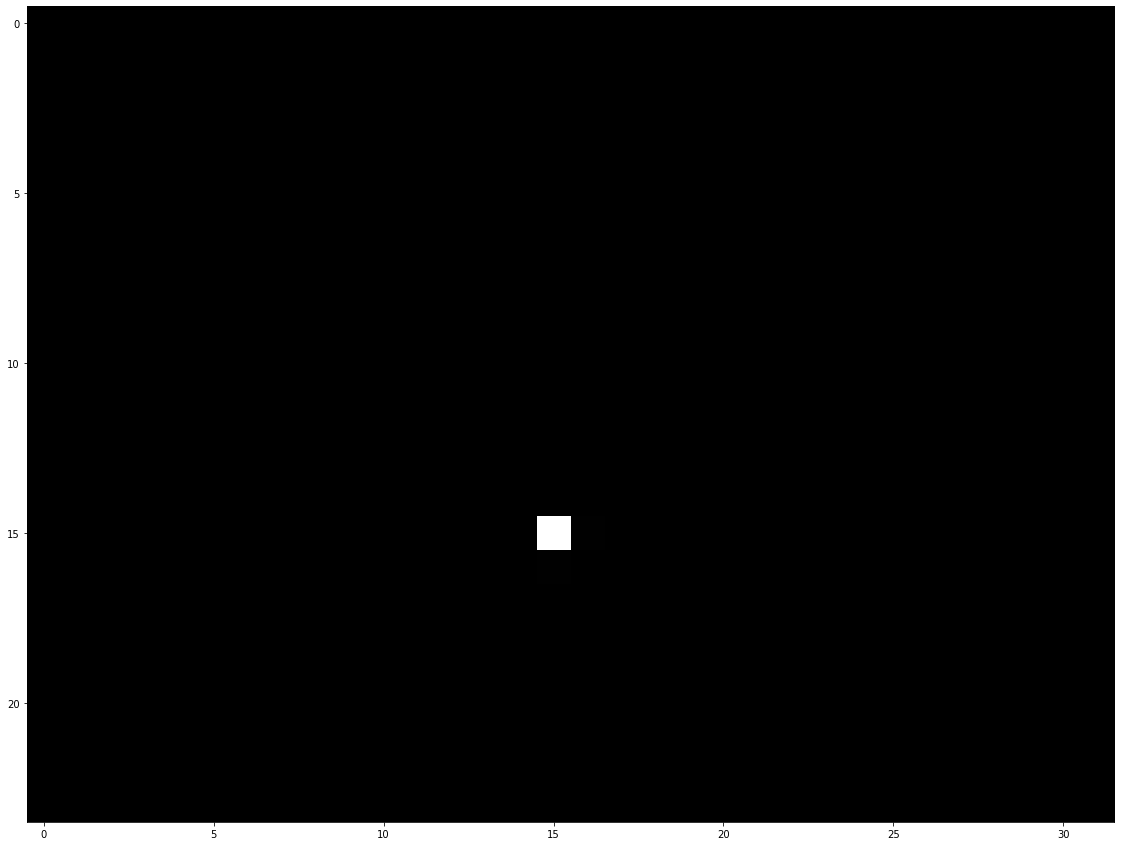

In [34]:
plt.figure(figsize=(30, 15))
plt.imshow(dm_resize, cmap='gray')
plt.show()

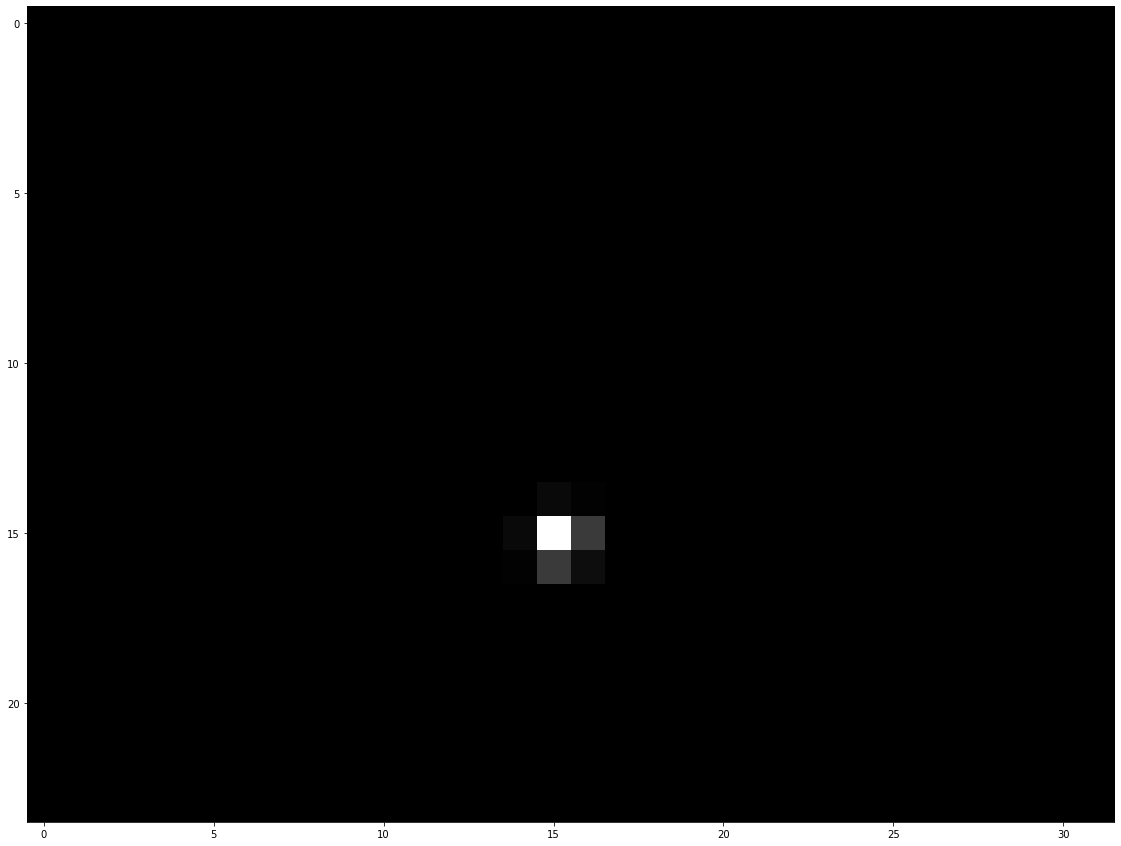

In [35]:
plt.figure(figsize=(30, 15))
plt.imshow(dm_resize1, cmap='gray')
plt.show()

In [41]:
print(np.sum(dm_resize))
print(np.sum(dm_resize1))

0.015625
0.015997995


In [42]:
ratio = np.sum(dm) / np.sum(dm_resize)

ratio1 = np.sum(dm) / np.sum(dm_resize1)

In [43]:
print(np.sum(dm_resize) * ratio)
print(np.sum(dm_resize1) * ratio1)

1.0
1.0


In [ ]:
tensor_test = np.zeros()